In [38]:
import kagglehub

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_recall_curve, average_precision_score

In [2]:
# https://www.kaggle.com/datasets/ealaxi/paysim1
path = kagglehub.dataset_download("ealaxi/paysim1") #synthetic financial data for fraud detection 
print("Path to dataset files:", path)
df = pd.read_csv(path + "\\data.csv")
df = df.drop(columns=["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"])
display(df.head())
print(df.shape)

Path to dataset files: C:\Users\mia.jensen\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,M1979787155,0,0
1,1,PAYMENT,"1,864.28",C1666544295,M2044282225,0,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0
4,1,PAYMENT,"11,668.14",C2048537720,M1230701703,0,0


(6362620, 7)


##### __About this dataset__

* PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service.
* The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.
* This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.
* Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) must not be used.
* Highly unbalanced, the positive class (frauds) account for very small proportion of all transactions. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

##### __Fields__

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* amount - amount of the transaction in local currency.
* nameOrig - customer who started the transaction
* oldbalanceOrg - initial balance before the transaction
* newbalanceOrig - new balance after the transaction.
* nameDest - customer who is the recipient of the transaction
* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

##### __Summary Statistics__

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   nameDest        object 
 5   isFraud         int64  
 6   isFlaggedFraud  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 339.8+ MB


In [43]:
df.describe()

,step,amount,isFraud,isFlaggedFraud
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90",0.00,0.00
std,142.33,"603,858.23",0.04,0.00
min,1.00,0.00,0.00,0.00
25%,156.00,"13,389.57",0.00,0.00
50%,239.00,"74,871.94",0.00,0.00
75%,335.00,"208,721.48",0.00,0.00
max,743.00,"92,445,516.64",1.00,1.00


In [44]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
nameDest          0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [45]:
df.duplicated().sum()

0

##### __EDA__

In [46]:
print(df.isFraud.value_counts())
print(f"\n{round((df.isFraud.value_counts()[1] / df.shape[0]) * 100, 4)}% fraudulent\n")

print(df.isFlaggedFraud.value_counts())
print(f"\n{round((df.isFlaggedFraud.value_counts()[1] / df.shape[0]) * 100, 4)}% flagged fraudulent\n")

isFraud
0    6354407
1       8213
Name: count, dtype: int64

0.1291% fraudulent

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

0.0003% flagged fraudulent



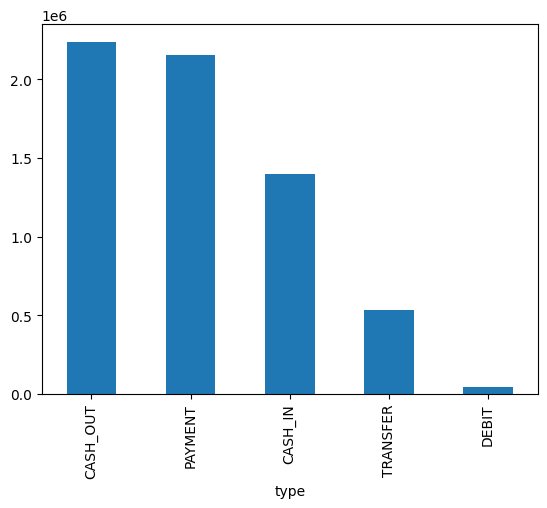

In [47]:
df['type'].value_counts().plot(kind='bar')
plt.show()

In [48]:
df_grouped = df.groupby(by=["type"]).agg({"isFraud": "sum", "isFlaggedFraud": "sum"}).reset_index()
df_grouped 

,type,isFraud,isFlaggedFraud
0,CASH_IN,0,0
1,CASH_OUT,4116,0
2,DEBIT,0,0
3,PAYMENT,0,0
4,TRANSFER,4097,16


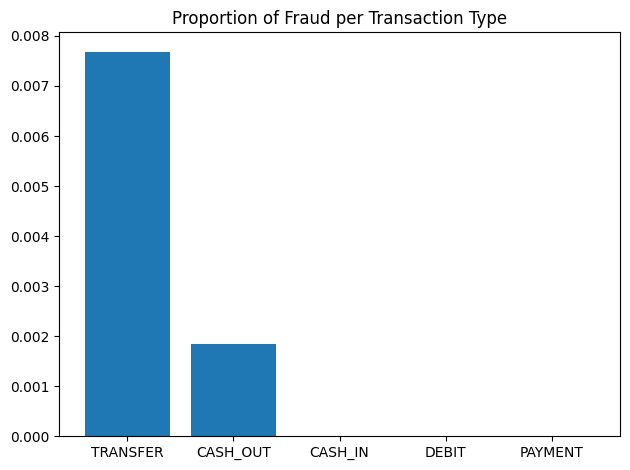

In [49]:
df_grouped = df.groupby(by=["type"]).agg({"isFraud": "mean"}).sort_values(by="isFraud", ascending=False).reset_index()
plt.bar(df_grouped['type'], df_grouped['isFraud'])
plt.title('Proportion of Fraud per Transaction Type')
plt.tight_layout()
plt.show() 

Fraud only occurs in transaction types cash out and transfer.

In [50]:
df["amount"].describe()

count    6,362,620.00
mean       179,861.90
std        603,858.23
min              0.00
25%         13,389.57
50%         74,871.94
75%        208,721.48
max     92,445,516.64
Name: amount, dtype: float64

In [51]:
df[df["isFraud"]==1]["amount"].describe()

count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64

In [52]:
df[df["isFlaggedFraud"]==1]["amount"].describe()

count           16.00
mean     4,861,597.73
std      3,572,499.10
min        353,874.22
25%      2,242,748.72
50%      4,234,245.09
75%      7,883,451.38
max     10,000,000.00
Name: amount, dtype: float64

Flagged fraud has minimum 353,874.22 and only appears under the transfer transaction type, indicating that this is a flag for high transfer amounts.

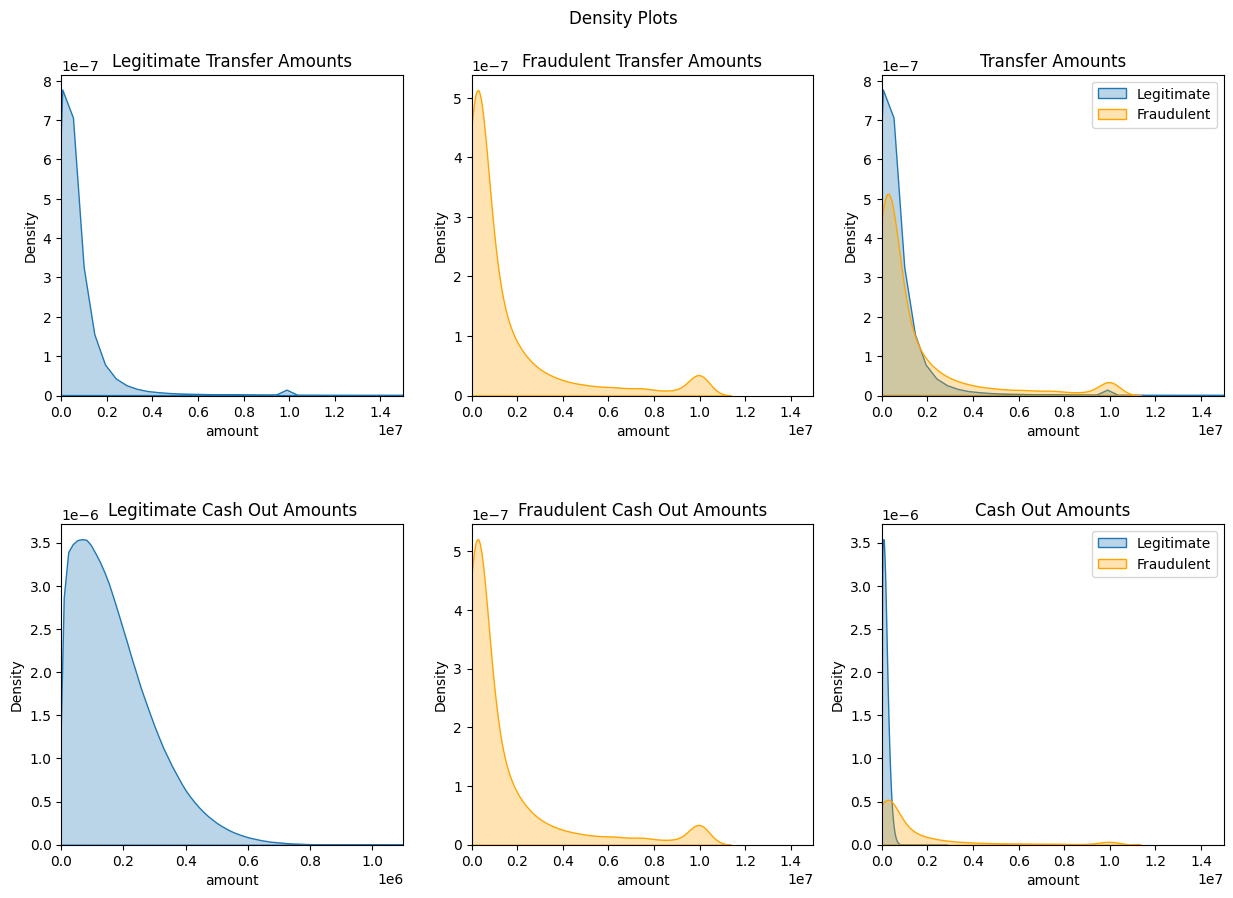

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

sns.kdeplot(df[(df["type"]=="TRANSFER") & (df["isFraud"]==0)], x="amount", fill=True, alpha=0.3, ax=ax[0][0])
ax[0][0].set_title("Legitimate Transfer Amounts")
ax[0][0].set_xlim(0, 1.5e7)

sns.kdeplot(df[(df["type"]=="CASH_OUT") & (df["isFraud"]==0)], x="amount", fill=True, alpha=0.3, ax=ax[1][0])
ax[1][0].set_title("Legitimate Cash Out Amounts")
ax[1][0].set_xlim(0, 0.11e7)

sns.kdeplot(df[(df["type"]=="TRANSFER") & (df["isFraud"]==1)], x="amount", fill=True, color="orange", alpha=0.3, ax=ax[0][1])
ax[0][1].set_title("Fraudulent Transfer Amounts")
ax[0][1].set_xlim(0, 1.5e7)

sns.kdeplot(df[(df["type"]=="CASH_OUT") & (df["isFraud"]==1)], x="amount", fill=True, color="orange", alpha=0.3, ax=ax[1][1])
ax[1][1].set_title("Fraudulent Cash Out Amounts")
ax[1][1].set_xlim(0, 1.5e7)

sns.kdeplot(df[(df["type"]=="TRANSFER") & (df["isFraud"]==0)], x="amount", fill=True, alpha=0.3, ax=ax[0][2], label='Legitimate')
sns.kdeplot(df[(df["type"]=="TRANSFER") & (df["isFraud"]==1)], x="amount", fill=True, color="orange", alpha=0.3, ax=ax[0][2], label='Fraudulent')
ax[0][2].legend(loc="upper right")
ax[0][2].set_title("Transfer Amounts")
ax[0][2].set_xlim(0, 1.5e7)

sns.kdeplot(df[(df["type"]=="CASH_OUT") & (df["isFraud"]==0)], x="amount", fill=True, alpha=0.3, ax=ax[1][2], label='Legitimate')
sns.kdeplot(df[(df["type"]=="CASH_OUT") & (df["isFraud"]==1)], x="amount", fill=True, color="orange", alpha=0.3, ax=ax[1][2], label='Fraudulent')
ax[1][2].legend(loc="upper right")
ax[1][2].set_title("Cash Out Amounts")
ax[1][2].set_xlim(0, 1.5e7)

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.suptitle("Density Plots", y=0.945)

plt.show()

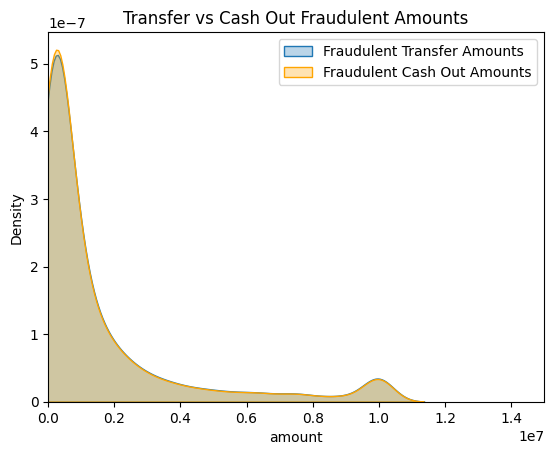

In [54]:
sns.kdeplot(df[(df["type"]=="TRANSFER") & (df["isFraud"]==1)], x="amount", fill=True, alpha=0.3, label='Fraudulent Transfer Amounts')
sns.kdeplot(df[(df["type"]=="CASH_OUT") & (df["isFraud"]==1)], x="amount", fill=True, color="orange", alpha=0.3, label='Fraudulent Cash Out Amounts')
plt.title("Transfer vs Cash Out Fraudulent Amounts")
plt.legend(loc="upper right")
plt.xlim(0, 1.5e7)
plt.show()

Similar densities across both fraudulent transfer and cashout transactions

In [55]:
# sns.kdeplot(np.log1p(df["amount"]), fill=True, alpha=0.3)
# plt.show()

# sns.kdeplot(np.log1p(df[(df["type"]=="TRANSFER") & (df["isFraud"]==0)]["amount"]), fill=True, alpha=0.3)
# plt.show()

##### __Preprocessing__

In [56]:
df_reduced = df.copy() 
df_reduced = df_reduced.drop(columns=["nameOrig", "nameDest"]) 
df_reduced.head() 

,step,type,amount,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",0,0
1,1,PAYMENT,"1,864.28",0,0
2,1,TRANSFER,181.00,1,0
3,1,CASH_OUT,181.00,1,0
4,1,PAYMENT,"11,668.14",0,0


In [57]:
df_encoded = df_reduced.copy()
df_dummies = pd.get_dummies(df_encoded['type']).astype(int) #.astype('category').cat.codes
df_encoded = pd.merge(df_encoded, df_dummies, left_index=True, right_index=True).drop(columns=["type"])
df_encoded.head()

,step,amount,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,"9,839.64",0,0,0,0,0,1,0
1,1,"1,864.28",0,0,0,0,0,1,0
2,1,181.00,1,0,0,0,0,0,1
3,1,181.00,1,0,0,1,0,0,0
4,1,"11,668.14",0,0,0,0,0,1,0


In [58]:
# corr_mat = df_encoded.corr()
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix')
# plt.show()

In [59]:
df_feat_eng = df_encoded.copy()
df_feat_eng['hour'] = df_feat_eng['step'] % 24
df_feat_eng['day'] = df_feat_eng['step'] // 24
df_feat_eng.head()

,step,amount,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,hour,day
0,1,"9,839.64",0,0,0,0,0,1,0,1,0
1,1,"1,864.28",0,0,0,0,0,1,0,1,0
2,1,181.00,1,0,0,0,0,0,1,1,0
3,1,181.00,1,0,0,1,0,0,0,1,0
4,1,"11,668.14",0,0,0,0,0,1,0,1,0


##### __Build Model - Assume Unlabelled__

In [60]:
df_model = df_model_copy = df_feat_eng.copy()
df_model = df_model.drop(columns=["step", "isFraud", "isFlaggedFraud"])
df_model

,amount,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,hour,day
0,"9,839.64",0,0,0,1,0,1,0
1,"1,864.28",0,0,0,1,0,1,0
2,181.00,0,0,0,0,1,1,0
3,181.00,0,1,0,0,0,1,0
4,"11,668.14",0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...
6362615,"339,682.13",0,1,0,0,0,23,30
6362616,"6,311,409.28",0,0,0,0,1,23,30
6362617,"6,311,409.28",0,1,0,0,0,23,30
6362618,"850,002.52",0,0,0,0,1,23,30


In [61]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_model)
df_scaled

array([[1.06437179e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       [2.01662565e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       [1.95790998e-06, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       ...,
       [6.82716643e-02, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.19463216e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.19463216e-03, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

##### ___Isolation Forest___

In [62]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_model['anomaly_score'] = isolation_forest.fit_predict(df_scaled)
df_model['is_anomaly'] = (df_model['anomaly_score'] == -1).astype(int) #anomalies are usually flagged with -1
print(df_model['is_anomaly'].value_counts())  # anomaly count 

is_anomaly
0    6298994
1      63626
Name: count, dtype: int64


In [63]:
df_isolation_forest = pd.merge(df_feat_eng, df_model[["anomaly_score", "is_anomaly"]], left_index=True, right_index=True)
df_isolation_forest.head()

,step,amount,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,hour,day,anomaly_score,is_anomaly
0,1,"9,839.64",0,0,0,0,0,1,0,1,0,1,0
1,1,"1,864.28",0,0,0,0,0,1,0,1,0,1,0
2,1,181.00,1,0,0,0,0,0,1,1,0,-1,1
3,1,181.00,1,0,0,1,0,0,0,1,0,1,0
4,1,"11,668.14",0,0,0,0,0,1,0,1,0,1,0


Area Under Precision-Recall Curve (AUPRC): 0.0131


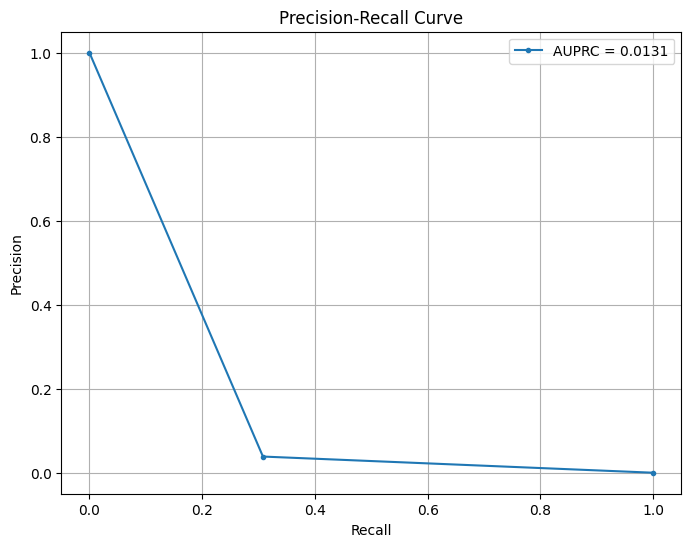

In [64]:
y_test = (df_isolation_forest['isFraud'] == 1).astype(int)
y_pred_prob = -df_isolation_forest['anomaly_score']  #invert the scores (more anomalous = higher probability)

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Area Under the Precision-Recall Curve (AUPRC)
auprc = average_precision_score(y_test, y_pred_prob)
print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

# plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f"AUPRC = {auprc:.4f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show() 

##### ___Isolation Forest (with PCA)___

In [67]:
df_model_isof_pca = df_model_copy.copy()

In [68]:
scaler = MinMaxScaler()
df_scaled_isof_pca = scaler.fit_transform(df_model_isof_pca)
df_scaled_isof_pca

array([[0.00000000e+00, 1.06437179e-04, 0.00000000e+00, ...,
        0.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       [0.00000000e+00, 2.01662565e-05, 0.00000000e+00, ...,
        0.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       [0.00000000e+00, 1.95790998e-06, 1.00000000e+00, ...,
        1.00000000e+00, 4.34782609e-02, 0.00000000e+00],
       ...,
       [1.00000000e+00, 6.82716643e-02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 9.19463216e-03, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 9.19463216e-03, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [70]:
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(df_scaled_isof_pca)
df_isof_pca = pd.DataFrame(data=principal_components)
df_isof_pca 

,0,1,2,3,4
0,-0.70,-0.33,-0.09,-0.49,-0.60
1,-0.70,-0.33,-0.09,-0.49,-0.60
2,-0.01,0.17,1.05,-0.51,-0.59
3,0.71,-0.29,-0.08,-0.48,-0.60
4,-0.70,-0.33,-0.09,-0.49,-0.60
...,...,...,...,...,...
6362615,0.70,-0.29,-0.05,0.99,0.27
6362616,-0.02,0.17,1.07,0.96,0.28
6362617,0.70,-0.29,-0.05,0.99,0.27
6362618,-0.02,0.17,1.07,0.96,0.28


In [73]:
isolation_forest_pca = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_model_isof_pca['is_anomaly'] = isolation_forest_pca.fit_predict(df_isof_pca)
df_model_isof_pca['is_anomaly'] = (df_model_isof_pca['is_anomaly'] == -1).astype(int) #anomalies are usually flagged with -1
df_model_isof_pca['score'] = isolation_forest_pca.decision_function(df_isof_pca)
print(df_model_isof_pca['is_anomaly'].value_counts())  # anomaly count 

is_anomaly
0    6299564
1      63056
Name: count, dtype: int64


In [75]:
df_isolation_forest_pca = pd.merge(df_feat_eng, df_model_isof_pca[["score", "is_anomaly"]], left_index=True, right_index=True)
df_isolation_forest_pca.head()

,step,amount,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,hour,day,score,is_anomaly
0,1,"9,839.64",0,0,0,0,0,1,0,1,0,0.04,0
1,1,"1,864.28",0,0,0,0,0,1,0,1,0,0.04,0
2,1,181.00,1,0,0,0,0,0,1,1,0,-0.04,1
3,1,181.00,1,0,0,1,0,0,0,1,0,0.03,0
4,1,"11,668.14",0,0,0,0,0,1,0,1,0,0.04,0


Area Under Precision-Recall Curve (AUPRC): 0.0114


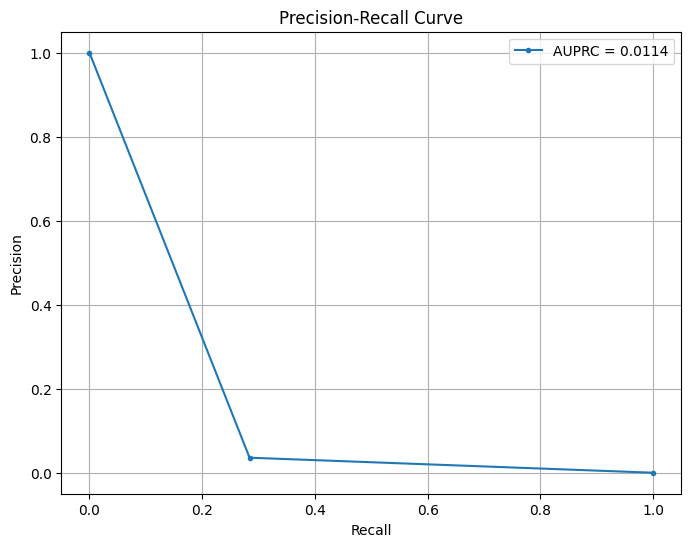

In [82]:
y_test = (df_isolation_forest_pca['isFraud'] == 1).astype(int)
y_pred = df_isolation_forest_pca['is_anomaly']

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Area Under the Precision-Recall Curve (AUPRC)
auprc = average_precision_score(y_test, y_pred)
print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

# plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f"AUPRC = {auprc:.4f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show() 

##### ___One-Class SVM___

##### ___DBSCAN for Clustering___